In [1]:
import numpy as np
from yaml import safe_load
import json
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import ICRS, get_sun, Longitude
from sunpy.coordinates.frames import Helioprojective

from helioschedule.get_local_noons import SolarTransiter
from helioschedule.schedule import DayScheduler

from matplotlib import pyplot as plt

In [2]:
SIDEREAL_FACTOR = 1.0027379093604878  # 86400/((1.0*units.sday).to(units.s).value)

In [3]:
conf = safe_load(open("John_MWA_FR_Triggered_1.yaml"))
azel = {int(k): v for k, v in json.load(open(conf["files"]["pointings"])).items()}

### Calculate local noon closest to reference time

In [4]:
# the following class abstracts dealing with skyfield

transiter = SolarTransiter(lat_deg_n=conf["lat"],
                            lon_deg_e=conf["lon"],
                            elevation_m=conf["alt"])

# note that I haven't calculated that this is the exact time that the CME crosses the meridian.
# As long as it is correct within an hour or so, this shouldn't actually matter, at least for
# this test
ref_time = Time(conf['refDate'])

# still need to supply times in skyfield type, but SolarTransiter
# has an attribute to make this easy.
local_noon = transiter.get_transit(transiter.ts.from_astropy(ref_time-12*u.hour),
                                   transiter.ts.from_astropy(ref_time+12*u.hour)).to_astropy().utc[0]
local_noon.isot, local_noon.gps
                                

('2024-06-17T04:14:18.149', 1402632876.1485736)

### Get Sun coordinates and calculate HA and Decl. of fields based on location of Sun at reference time.

For scheduling purposes, the coordinates required for each target are the Hour Angle *relative to the Sun* and the Declination, both in Degrees.

Note that the code in `convert_coordinates.py` which does this is not particularly accurate or fast (in part because it dates from before `sunpy` was mature). But it is good enough to make updating it a low priority. 

Here we can use `sunpy` for much more readable code.  Note that `Tx` is west positive, whereas for the yaml file, we measure position angle as North through East.

In [14]:
sun = get_sun(ref_time)
has = {}
decs = {}
for c in conf['priority']:
    print(c, end=' ')
    print(conf['fields'][c]['coordinates'], end=' ')
    # NB X is 
    hpc = Helioprojective(Tx=-conf['fields'][c]['coordinates'][0]*u.deg*np.sin(np.radians(conf['fields'][c]['coordinates'][1])),
                          Ty=conf['fields'][c]['coordinates'][0]*u.deg*np.cos(np.radians(conf['fields'][c]['coordinates'][1])),
                          distance=1*u.Mpc,
                          obstime = ref_time,
                          observer='earth')
    radec = hpc.transform_to(ICRS())
    has[c]=Longitude(radec.ra - sun.ra, wrap_angle=180 * u.deg).deg
    decs[c]=radec.dec.deg


CME_1B_121 [25.0, 120.0] CME_1A_121 [25.0, 100.0] CME_1C_121 [25.0, 140.0] 

In [15]:
#print(radec.dec.deg)
has

{'CME_1B_121': 23.476338600862306,
 'CME_1A_121': 26.779623493850934,
 'CME_1C_121': 18.067926474966683}

Set up Scheduler object

In [16]:
scheduler = DayScheduler(conf=conf)
schedule = scheduler.schedule_day(solar_noon_gps=local_noon.gps,
                                  local_noon_str=local_noon.isot,
                                  has=has, decs=decs, dec_sun=sun.dec.deg,
                                  ref_time_gps = ref_time.gps)
                

In [17]:
schedule

{'ha_idx_CME_1B_121': 129,
 'beam_CME_1B_121': 61,
 'sun_attenuation_CME_1B_121': -3.0007584252682187,
 'starttime_CME_1B_121': 1402635080.0,
 'target_sensitivity_CME_1B_121': 0.47904506354978477,
 'unflagged_before_CME_1B_121': 91,
 'unflagged_after_CME_1B_121': 189,
 'ha_idx_CME_1A_121': 393,
 'beam_CME_1A_121': 49,
 'sun_attenuation_CME_1A_121': -3.1881046390096635,
 'starttime_CME_1A_121': 1402637192.0,
 'target_sensitivity_CME_1A_121': 0.17061544389690128,
 'unflagged_before_CME_1A_121': 188,
 'unflagged_after_CME_1A_121': 129,
 'ha_idx_CME_1C_121': 597,
 'beam_CME_1C_121': 45,
 'sun_attenuation_CME_1C_121': -3.002689467311539,
 'starttime_CME_1C_121': 1402638824.0,
 'target_sensitivity_CME_1C_121': 0.5099338596842284,
 'unflagged_before_CME_1C_121': 128,
 'unflagged_after_CME_1C_121': 133}

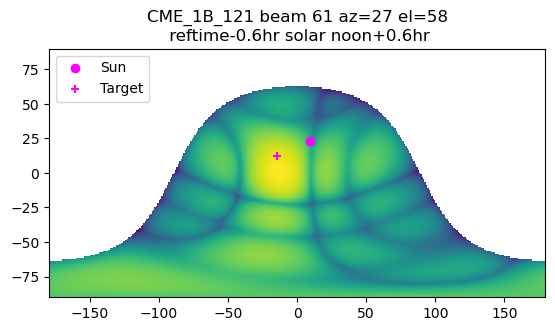

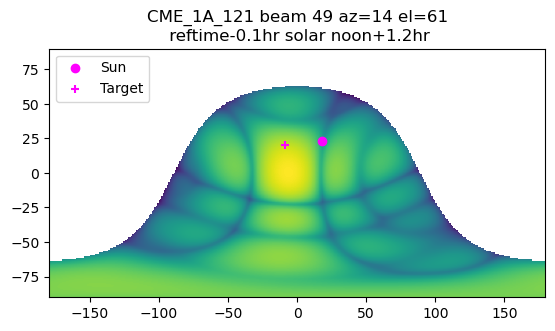

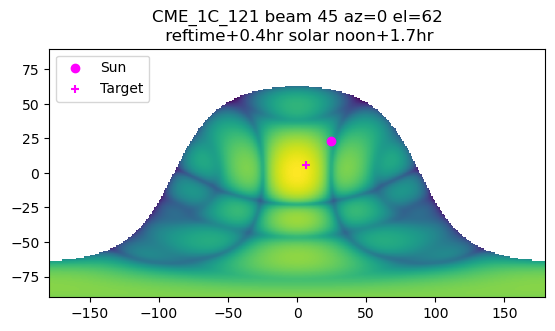

In [18]:
ha_scale =  scheduler.beams.df["beams"].dims[3][0]
dec_scale = scheduler.beams.df["beams"].dims[2][0]
for c in conf['priority']:
    freq_idx = scheduler.beams.beam_str_to_idx(conf["fields"][c]["beam_chan"])
    sweetspot=schedule[f"beam_{c}"]
    beam_idx = np.where(scheduler.beams.df["beams"].dims[1][0]==sweetspot)[0][0]
    beam = scheduler.beams.df["beams"][freq_idx, beam_idx, ...]
    plt.figure()
    plt.imshow(np.log10(beam), origin='lower', extent=[ha_scale[0], ha_scale[-1], dec_scale[0], dec_scale[-1]])
    starttime = schedule[f"starttime_{c}"]
    sun_ha = 360*(starttime-local_noon.gps)/86400.
    plt.scatter([sun_ha], [sun.dec.deg], color='magenta', label='Sun')
    plt.scatter([sun_ha-has[c]], [decs[c]], marker='+', color='magenta', label='Target')
    plt.title(f"{c} beam {sweetspot} az={azel[sweetspot][0]:.0f} el={azel[sweetspot][1]:.0f}\n reftime{(starttime-ref_time.gps)/3600.:+.1f}hr solar noon{(starttime-local_noon.gps)/3600.:+.1f}hr" )
    plt.legend(loc='upper left')